<div class="alert alert-block alert-info">  
    <center><h1><strong>👨‍💻 Getting Started with Few Shot Learning</strong></h1></center>
    <i></i>
</div>

<div class="alert alert-block alert-danger">  
<h2><center><strong>Importing Python Libraries 📕 📗 📘 📙</strong></center></h2>
        
</div>

In [1]:
#!pip install -r libraries_to_install.txt

In [2]:
import os
import random
import numpy as np
import torch
from torch import nn
from tqdm import tqdm
from pathlib import Path
from statistics import mean
import torchvision.models as models
from easyfsl.methods.utils import evaluate
from torch.optim import SGD, Optimizer
from torch.optim.lr_scheduler import MultiStepLR
from easyfsl.methods import PrototypicalNetworks, FewShotClassifier
from easyfsl.modules import resnet12
from easyfsl.datasets import PLANT
from easyfsl.samplers import TaskSampler
from torch.utils.data import DataLoader
import matplotlib.image as mpimg
from PIL import Image
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [3]:
if torch.cuda.is_available()==True:
    print('GPUs are available! ')
else:
    print('Please configure GPSs are not available')

GPUs are available! 


<div class="alert alert-block alert-danger">  
<h2><center><strong>Exploratory data analysis 🔎 📊</strong></center></h2>
        
</div>

- Exploration of data is not neccessory for training the model but its a good practice to look at the dataset so that we can analyse that what type of data we are using and how we can handle it.

# Sample images

(256, 256, 3)


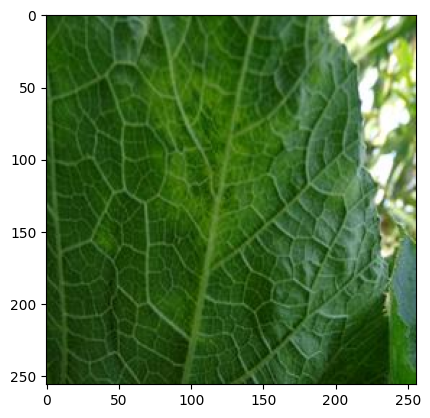

In [4]:
img = mpimg.imread('./data/PLANT/100/DSC05982.jpg')
print(img.shape)
plt.imshow(img)

(256, 256, 3)


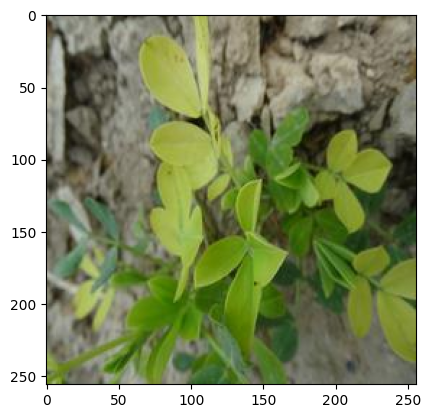

In [5]:
img = mpimg.imread('./data/PLANT/256/DSC09062.jpg')
print(img.shape)
plt.imshow(img)

(256, 256, 3)


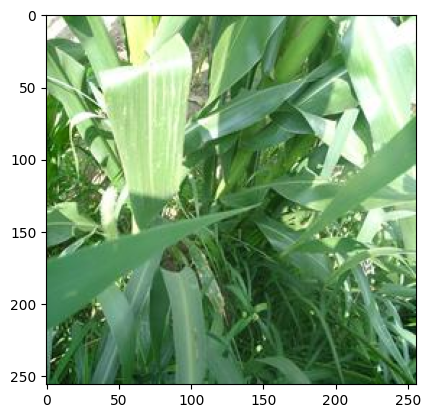

In [6]:
img = mpimg.imread('./data/PLANT/316/DSC03840.jpg')
print(img.shape)
plt.imshow(img)

(256, 256, 3)


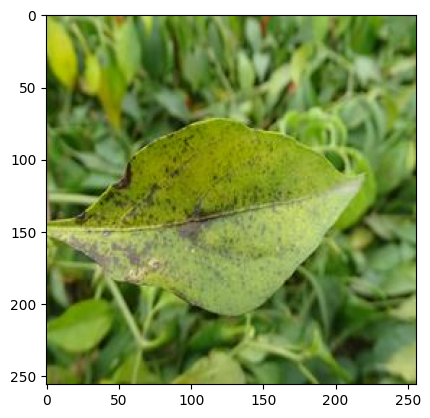

In [7]:
img = mpimg.imread('./data/PLANT/330/DSC06136.jpg')
print(img.shape)
plt.imshow(img)

(256, 256, 3)


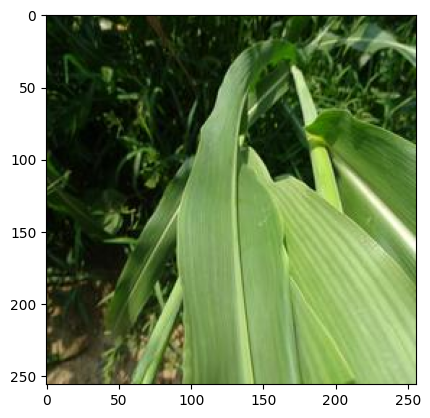

In [8]:
img = mpimg.imread('./data/PLANT/348/DSC01037.jpg')
print(img.shape)
plt.imshow(img)

(256, 256, 3)


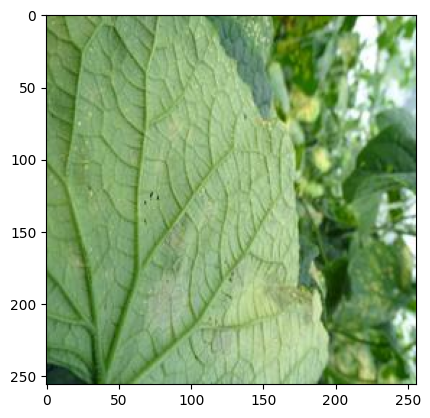

In [9]:
img = mpimg.imread('./data/PLANT/370/DSC01163.jpg')
print(img.shape)
plt.imshow(img)

### Some random Imeges of  class 110

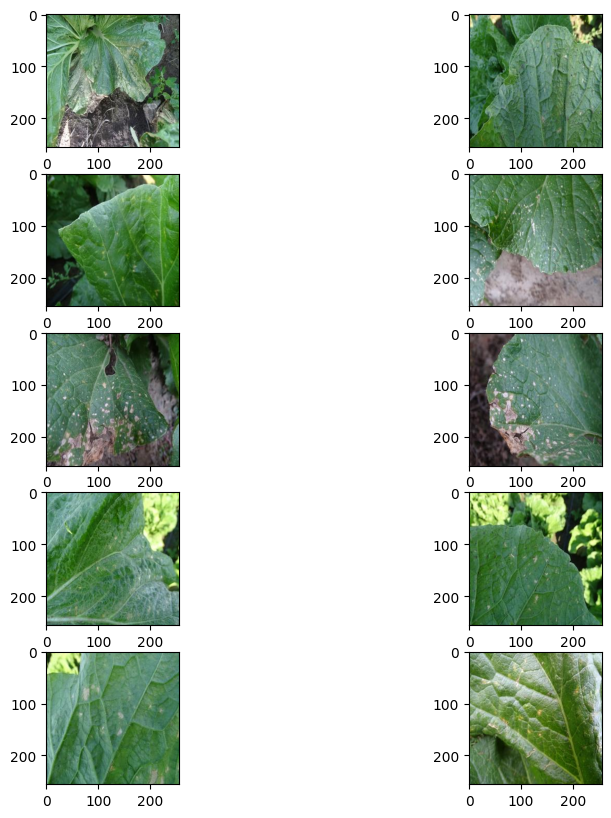

In [10]:
images_data = []
for i in os.listdir('./data/PLANT/110/')[0:10]:
    split = i.split('_')
    images_data.append(Image.open('./data/PLANT/110/' + i))
plt.figure(figsize=(10,10))
for i in range(10):
    plt.subplot(5,2,i+1)
    plt.imshow(images_data[i])
plt.show()

### Some random Imeges of  class 150

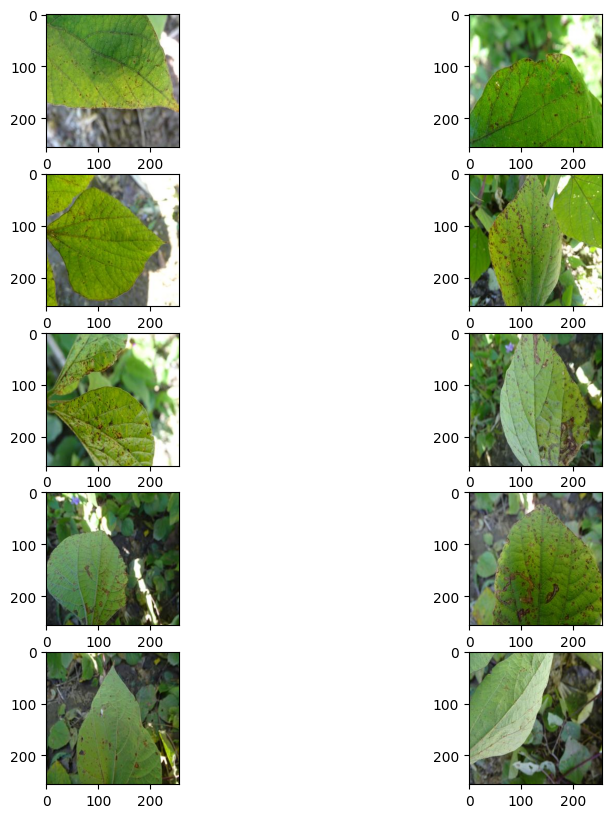

In [11]:
images_data = []
for i in os.listdir('./data/PLANT/150/')[0:10]:
    split = i.split('_')
    images_data.append(Image.open('./data/PLANT/150/' + i))
plt.figure(figsize=(10,10))
for i in range(10):
    plt.subplot(5,2,i+1)
    plt.imshow(images_data[i])
plt.show()

### Some random Imeges of  class 200

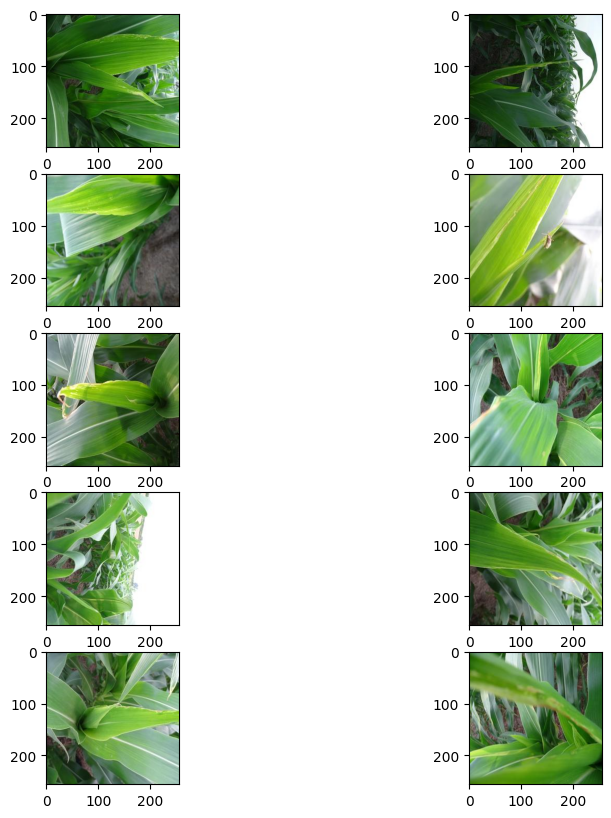

In [12]:
images_data = []
for i in os.listdir('./data/PLANT/200/')[0:10]:
    split = i.split('_')
    images_data.append(Image.open('./data/PLANT/200/' + i))
plt.figure(figsize=(10,10))
for i in range(10):
    plt.subplot(5,2,i+1)
    plt.imshow(images_data[i])
plt.show()

### Some random Imeges of  class 370

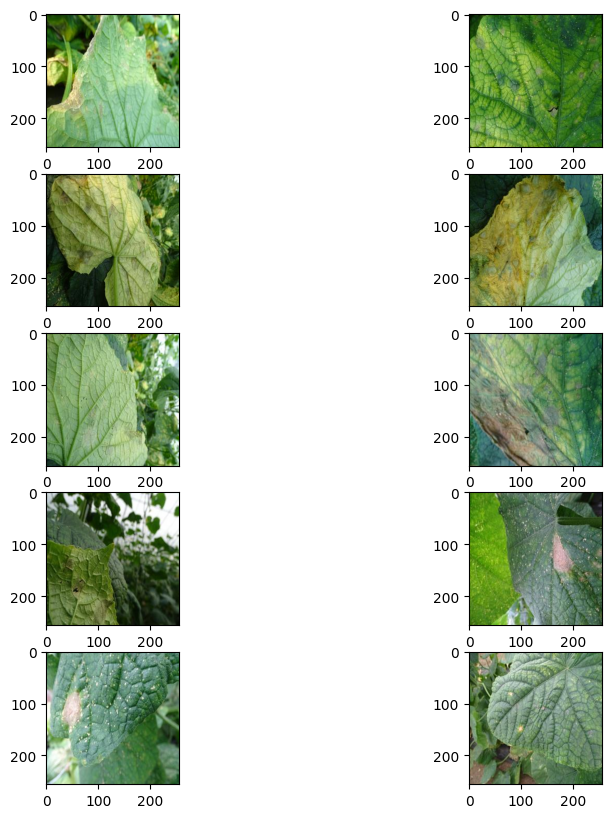

In [13]:
images_data = []
for i in os.listdir('./data/PLANT/370/')[0:10]:
    split = i.split('_')
    images_data.append(Image.open('./data/PLANT/370/' + i))
plt.figure(figsize=(10,10))
for i in range(10):
    plt.subplot(5,2,i+1)
    plt.imshow(images_data[i])
plt.show()

<b> <h3> Training Data </h3></b>  We use training data when we train the models. We feed train data to machine learning and deep learning models so that model can learn from the data.

<b> <h3> Validation Data </h3></b>  We use validation data while training the model. We use this data to evalaute the performance that how the model perform on training time.

<b> <h3> Testing Data </h3></b>  We use testing data after training the model. We use this data to evalaute the performance that how the model perform after training. So in this way first we get predictions from the trained model without giving the labels and then we compare the true labels with predictions and get the performance of th model..

### Setting of classes and per class samples.

In [15]:
n_way = 271 # number of classes
n_shot = 1 #number of samples 
n_query = 1 # Number of images per class in the query set

DEVICE = "cuda"
n_workers = 5

## Data Preparation of Training and Validation

In [16]:
n_tasks_per_epoch = 2000
n_validation_tasks = 2000

train_set = PLANT(split="train", training=True)
val_set = PLANT(split="test", training=False)

train_sampler = TaskSampler(
    train_set, n_way=n_way, n_shot=n_shot, n_query=n_query, n_tasks=n_tasks_per_epoch
)
val_sampler = TaskSampler(
    val_set, n_way=n_way, n_shot=n_shot, n_query=n_query, n_tasks=n_validation_tasks
)

### Training data loader

In [17]:
train_loader = DataLoader(
    train_set,
    batch_sampler=train_sampler,
    num_workers=n_workers,
    pin_memory=True,
    collate_fn=train_sampler.episodic_collate_fn,
)

### Validation data loader

In [18]:
val_loader = DataLoader(
    val_set,
    batch_sampler=val_sampler,
    num_workers=n_workers,
    pin_memory=True,
    collate_fn=val_sampler.episodic_collate_fn,
)

<div class="alert alert-block alert-info">  
    <center><h1><strong>👨Using the Googlenet as transfer learning</strong></h1></center>
    <i></i>
</div>

In [19]:
tranfer_learning_model = models.googlenet(pretrained=True)

## Using the tranfser learning in Few Shot Leanring 

In [20]:
few_shot_classifier = PrototypicalNetworks(tranfer_learning_model).to(DEVICE)

## Hyper parameter tuning for the Few Shot Learning model

In [21]:
LOSS_FUNCTION = nn.CrossEntropyLoss()
n_epochs = 50
scheduler_milestones = [20, 30]
scheduler_gamma = 0.1
learning_rate = 1e-2

train_optimizer = SGD(
    few_shot_classifier.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4
)
train_scheduler = MultiStepLR(
    train_optimizer,
    milestones=scheduler_milestones,
    gamma=scheduler_gamma,
)

## Setting the function of epoch to monitor the real time logs

In [22]:
def training_epoch(
    model: FewShotClassifier, data_loader: DataLoader, optimizer: Optimizer
):
    all_loss = []
    model.train()
    with tqdm(
        enumerate(data_loader), total=len(data_loader), desc="Training"
    ) as tqdm_train:
        for episode_index, (
            support_images,
            support_labels,
            query_images,
            query_labels,
            _,
        ) in tqdm_train:
            optimizer.zero_grad()
            model.process_support_set(
                support_images.to(DEVICE), support_labels.to(DEVICE)
            )
            classification_scores = model(query_images.to(DEVICE))

            loss = LOSS_FUNCTION(classification_scores, query_labels.to(DEVICE))
            loss.backward()
            optimizer.step()

            all_loss.append(loss.item())

            tqdm_train.set_postfix(loss=mean(all_loss))

    return mean(all_loss)

## Start training the Few Shot Learning model

In [23]:
best_state = few_shot_classifier.state_dict()
best_validation_accuracy = 0.0
for epoch in range(n_epochs):
    print(f"Epoch {epoch}")
    average_loss = training_epoch(few_shot_classifier, train_loader, train_optimizer)
    validation_accuracy = evaluate(
        few_shot_classifier, val_loader, device=DEVICE, tqdm_prefix="Validation"
    )

    if validation_accuracy > best_validation_accuracy:
        best_validation_accuracy = validation_accuracy
        best_state = few_shot_classifier.state_dict()
    train_scheduler.step()

Epoch 0


Validation: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:02<00:00,  6.11it/s, accuracy=0.241]


Epoch 1


Validation: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:05<00:00,  2.61it/s, accuracy=0.242]


Epoch 2


Validation: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:05<00:00,  2.50it/s, accuracy=0.244]


Epoch 3


Validation: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:05<00:00,  2.73it/s, accuracy=0.246]


Epoch 4


Validation: 100%|███████████████████████████████████████████████████████| 2000/2000 [00:05<00:00,  2.52it/s, accuracy=0.247]


Epoch 5


Validation: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:05<00:00,  2.36it/s, accuracy=0.254]


Epoch 6


Validation: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:06<00:00,  2.15it/s, accuracy=0.259]


Epoch 7


Validation: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:06<00:00,  2.16it/s, accuracy=0.262]


Epoch 8


Validation: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:05<00:00,  2.59it/s, accuracy=0.274]


Epoch 9


Validation: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:06<00:00,  2.17it/s, accuracy=0.279]


Epoch 10


Validation: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:07<00:00,  1.95it/s, accuracy=0.282]


Epoch 11


Validation: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:08<00:00,  1.70it/s, accuracy=0.284]


Epoch 12


Validation: 100%|███████████████████████████████████████████████████████| 2000/2000 [00:36<00:00,  2.63s/it, accuracy=0.301]


Epoch 13


Validation: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:06<00:00,  2.07it/s, accuracy=0.324]


Epoch 14


Validation: 100%|███████████████████████████████████████████████████████| 2000/2000 [00:06<00:00,  2.07it/s, accuracy=0.338]


Epoch 15


Validation: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:06<00:00,  2.07it/s, accuracy=0.346]


Epoch 16


Validation: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:06<00:00,  2.00it/s, accuracy=0.352]


Epoch 17


Validation: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:06<00:00,  2.07it/s, accuracy=0.354]


Epoch 18


Validation: 100%|███████████████████████████████████████████████████████| 2000/2000 [00:09<00:00,  1.52it/s, accuracy=0.355]


Epoch 19


Validation: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:06<00:00,  2.12it/s, accuracy=0.369]


Epoch 20


Validation: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:08<00:00,  1.70it/s, accuracy=0.378]


Epoch 21


Validation: 100%|████████████████████████████████████████████████████████| 2000/2000 [00:08<00:00,  1.62it/s, accuracy=0.38]


Epoch 22


Validation: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:09<00:00,  1.44it/s, accuracy=0.384]

Epoch 23



Validation: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:07<00:00,  1.85it/s, accuracy=0.393]


Epoch 24


Validation: 100%|███████████████████████████████████████████████████████| 2000/2000 [00:07<00:00,  1.95it/s, accuracy=0.396]


Epoch 25


Validation: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:07<00:00,  1.81it/s, accuracy=0.413]


Epoch 26


Validation: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:08<00:00,  1.64it/s, accuracy=0.414]


Epoch 27


Validation: 100%|███████████████████████████████████████████████████████| 2000/2000 [00:07<00:00,  1.86it/s, accuracy=0.417]


Epoch 28


Validation: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:09<00:00,  1.50it/s, accuracy=0.423]


Epoch 29


Validation: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:07<00:00,  1.80it/s, accuracy=0.424]


Epoch 30


Validation: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:09<00:00,  1.46it/s, accuracy=0.425]


Epoch 31


Validation: 100%|████████████████████████████████████████████████████████| 2000/2000 [00:08<00:00,  1.71it/s, accuracy=0.43]


Epoch 32


Validation: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:07<00:00,  1.78it/s, accuracy=0.432]


Epoch 33


Validation: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:11<00:00,  1.21it/s, accuracy=0.441]


Epoch 34


Validation: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:09<00:00,  1.47it/s, accuracy=0.447]


Epoch 35


Validation: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:11<00:00,  1.27it/s, accuracy=0.453]


Epoch 36


Validation: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:08<00:00,  1.62it/s, accuracy=0.466]


Epoch 37


Validation: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:09<00:00,  1.44it/s, accuracy=0.467]


Epoch 38


Validation: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:09<00:00,  1.45it/s, accuracy=0.478]


Epoch 39


Validation: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:10<00:00,  1.28it/s, accuracy=0.491]


Epoch 40


Validation: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:08<00:00,  1.59it/s, accuracy=0.495]


Epoch 41


Validation: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:07<00:00,  1.82it/s, accuracy=0.512]


Epoch 42


Validation: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:09<00:00,  1.49it/s, accuracy=0.513]


Epoch 43


Validation: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:08<00:00,  1.75it/s, accuracy=0.513]


Epoch 44


Validation: 100%|███████████████████████████████████████████████████████| 2000/2000 [00:08<00:00,  1.62it/s, accuracy=0.533]


Epoch 45


Validation: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:10<00:00,  1.39it/s, accuracy=0.536]


Epoch 46


Validation: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:11<00:00,  1.23it/s, accuracy=0.537]


Epoch 47


Validation: 100%|███████████████████████████████████████████████████████| 2000/2000 [00:07<00:00,  1.89it/s, accuracy=0.54]


Epoch 48


Validation: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:07<00:00,  1.75it/s, accuracy=0.554]


Epoch 49


Validation: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:08<00:00,  1.72it/s, accuracy=0.564]


## Using the best model state from the above experimnents

In [24]:
few_shot_classifier.load_state_dict(best_state)

<All keys matched successfully>

## Evaluation of trained model using test data

### Loading the test data using data loader 

In [25]:
n_test_tasks = 2000

test_set = PLANT(split="test", training=False)
test_sampler = TaskSampler(
    test_set, n_way=n_way, n_shot=n_shot, n_query=n_query, n_tasks=n_test_tasks
)
test_loader = DataLoader(
    test_set,
    batch_sampler=test_sampler,
    num_workers=n_workers,
    pin_memory=True,
    collate_fn=test_sampler.episodic_collate_fn,
)

### Calculating the accuracy

In [26]:
accuracy = evaluate(few_shot_classifier, test_loader, device=DEVICE)
print(f"Average accuracy : {(100 * accuracy):.1f} %")

100%|██████████████████████████████████████████████████████████████████| 2000/2000 [00:07<00:00,  1.76it/s, accuracy=0.559]

Average accuracy : 55.9 %
